## Problem Statement

The objective of this analysis is to segment users based on their behavioral patterns using unsupervised machine learning (clustering).
The resulting user segments are intended to support business insights and will be visualized through an interactive Tableau dashboard.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("events_fixx.csv")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,unknown,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,unknown,unknown,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,unknown,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


Dataset sudah melalui cleaning & feature engineering sebelumnya

Fokus notebook ini = modeling & dashboard output

## User-Level Feature Engineering

Event-level data is aggregated into user-level behavioral features to serve as input for the clustering model.

In [3]:
user_features = df.groupby("user_id").agg(
    total_events=("event_type", "count"),
    total_views=("event_type", lambda x: (x == "view").sum()),
    total_carts=("event_type", lambda x: (x == "cart").sum()),
    total_purchases=("event_type", lambda x: (x == "purchase").sum()),
    avg_price=("price", "mean"),
    unique_products=("product_id", "nunique"),
    unique_categories=("category_code", "nunique"),
    unique_sessions=("user_session", "nunique")
).reset_index()

user_features.head()


,user_id,total_events,total_views,total_carts,total_purchases,avg_price,unique_products,unique_categories,unique_sessions
0,1515915625353226922,1,1,0,0,76.480000,1,1,1
1,1515915625353230067,1,1,0,0,28.980000,1,1,1
2,1515915625353230683,13,13,0,0,62.686923,10,2,4
3,1515915625353230922,1,1,0,0,274.400000,1,1,1
4,1515915625353234047,36,36,0,0,152.275000,8,3,1


In [4]:
user_features["conversion_rate"] = (
    user_features["total_purchases"] / user_features["total_views"]
).replace([np.inf, np.nan], 0)

user_features.describe()


,user_id,total_events,total_views,total_carts,total_purchases,avg_price,unique_products,unique_categories,unique_sessions,conversion_rate
count,4.072370e+05,407237.000000,407237.000000,407237.000000,407237.000000,407237.000000,407237.000000,407237.000000,407237.000000,407237.000000
mean,1.515916e+18,2.171492,1.947129,0.132665,0.091698,129.279100,1.366863,1.046432,1.204785,0.031280
std,3.358157e+07,4.405577,3.816656,0.672456,0.557732,293.303884,1.562167,0.309682,1.278927,0.182899
min,1.515916e+18,1.000000,0.000000,0.000000,0.000000,0.220000,1.000000,1.000000,1.000000,0.000000
25%,1.515916e+18,1.000000,1.000000,0.000000,0.000000,22.700000,1.000000,1.000000,1.000000,0.000000
50%,1.515916e+18,1.000000,1.000000,0.000000,0.000000,55.160000,1.000000,1.000000,1.000000,0.000000
75%,1.515916e+18,2.000000,2.000000,0.000000,0.000000,145.400000,1.000000,1.000000,1.000000,0.000000
max,1.515916e+18,572.000000,572.000000,91.000000,56.000000,64771.060000,169.000000,29.000000,254.000000,9.000000


## Feature Selection

Only numerical and behaviorally meaningful features are used for clustering.


In [5]:
features_for_clustering = [
    "total_events",
    "total_views",
    "total_carts",
    "total_purchases",
    "avg_price",
    "unique_products",
    "unique_categories",
    "unique_sessions",
    "conversion_rate"
]

X = user_features[features_for_clustering]


## Feature Scaling

Standardization is applied to ensure all features contribute equally to the clustering algorithm.


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Elbow Method

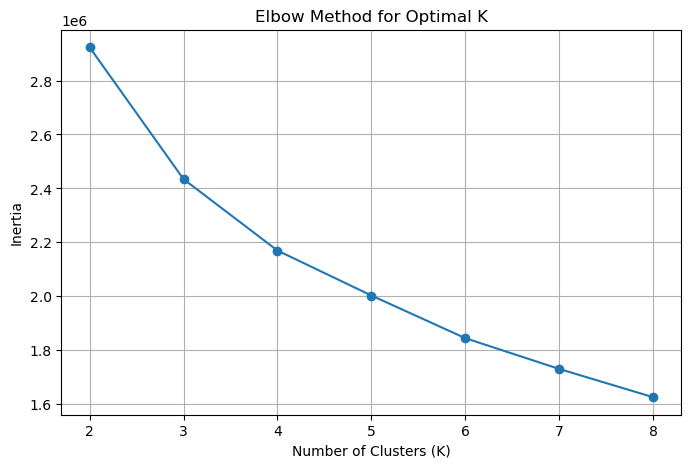

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()


## PCA

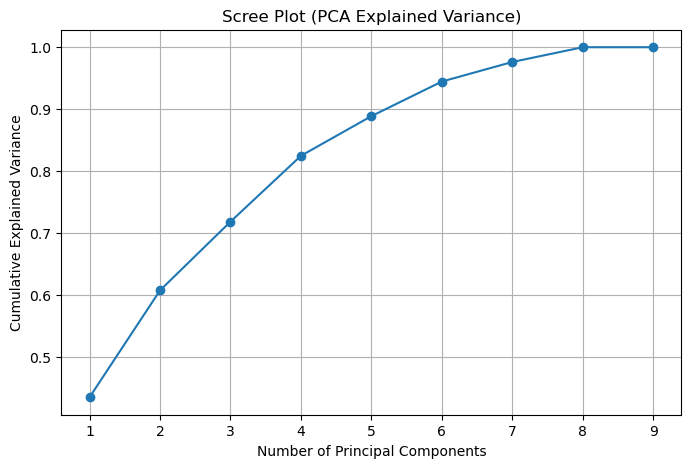

In [8]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
pca.fit(X_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot (PCA Explained Variance)")
plt.grid(True)
plt.show()


## User Clustering Model

K-Means clustering is applied to segment users based on their behavioral features.


In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
user_features["cluster"] = kmeans.fit_predict(X_scaled)

user_features["cluster"].value_counts().sort_index()


cluster
0    383091
1       450
2      8178
3     15518
Name: count, dtype: int64

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

user_features["pca_1"] = X_pca[:, 0]
user_features["pca_2"] = X_pca[:, 1]


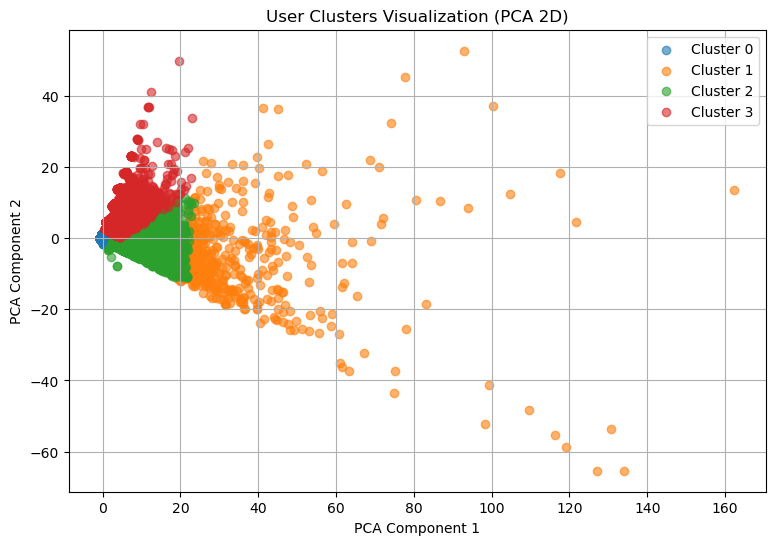

In [11]:
plt.figure(figsize=(9, 6))

for cluster in sorted(user_features["cluster"].unique()):
    subset = user_features[user_features["cluster"] == cluster]
    plt.scatter(
        subset["pca_1"],
        subset["pca_2"],
        label=f"Cluster {cluster}",
        alpha=0.6
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("User Clusters Visualization (PCA 2D)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 9), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by Number of Clusters")
plt.grid(True)
plt.show()


## Cluster Profiling

Cluster characteristics are analyzed to support interpretation and business insights.


In [12]:
cluster_profile = user_features.groupby("cluster")[features_for_clustering].mean()
cluster_profile


,total_events,total_views,total_carts,total_purchases,avg_price,unique_products,unique_categories,unique_sessions,conversion_rate
cluster,,,,,,,,,
0,1.627109,1.571841,0.047981,0.007288,127.534542,1.219890,1.019309,1.131172,0.001282
1,83.880000,70.746667,8.653333,4.480000,199.779305,24.153333,4.335556,15.111111,0.100690
2,15.704573,13.692712,1.313646,0.698215,220.888394,6.833822,2.111274,3.237589,0.054775
3,6.109228,3.026808,1.353783,1.728638,122.024204,1.453280,1.059479,1.547493,0.757455


## Cluster Interpretation


In [13]:
cluster_names = {
    0: "Low Activity Users",
    1: "High Browsers",
    2: "Potential Buyers",
    3: "High Value Customers"
}

user_features["cluster_name"] = user_features["cluster"].map(cluster_names)

user_features[["user_id", "cluster", "cluster_name"]].head()


,user_id,cluster,cluster_name
0,1515915625353226922,0,Low Activity Users
1,1515915625353230067,0,Low Activity Users
2,1515915625353230683,2,Potential Buyers
3,1515915625353230922,0,Low Activity Users
4,1515915625353234047,2,Potential Buyers


## Tableau Dataset Export

The final dataset includes user-level features and cluster labels for dashboard visualization.


In [14]:
user_features.to_csv("user_clustering.csv", index=False)